# Note:
###### Don't run the programe, the server von't run it, in addetion it will take time and freaze the computer.

# Object:
#### we will learn how to build a classifier using Convolution Neural Network which can classify normal lung tissues from cancerous tissues.

##### The link of the project:
* https://www.geeksforgeeks.org/deep-learning/lung-cancer-detection-using-convolutional-neural-network-cnn/

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

from zipfile import ZipFile
# import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, MaxPool2D

import warnings
warnings.filterwarnings('ignore')

### Extraction of the zip file

In [2]:
'''
zip_path = 'lung_colon_image_set.zip'

with ZipFile(zip_path, 'r') as zip:
    zip.extractall()
    print('The data set has been extracted.')
'''

"\nzip_path = 'lung_colon_image_set.zip'\n\nwith ZipFile(zip_path, 'r') as zip:\n    zip.extractall()\n    print('The data set has been extracted.')\n"

### Visualizing the Data

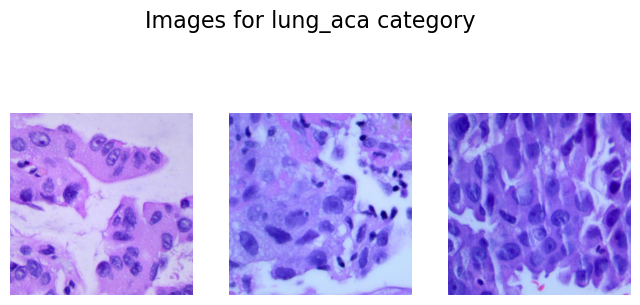

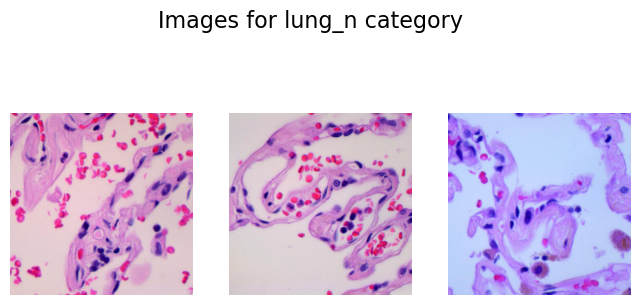

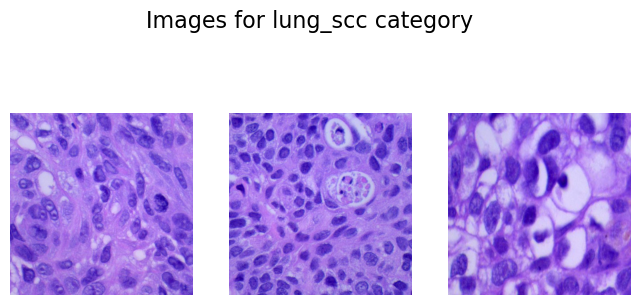

In [3]:
path = r'C:\Users\Mewandi\Desktop\MI\Convelutional_Neural_Network\lung_image_sets'
classes = ['lung_aca', 'lung_n', 'lung_scc']

for cate in classes:
    img_dir = f'{path}\{cate}'
    images = os.listdir(img_dir)
    fig, axes = plt.subplots(1, 3, figsize=(8,4))
    fig.suptitle(f"Images for {cate} category", fontsize=16)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}\{cate}\{images[k]}'))
        axes[i].imshow(img)
        axes[i].axis('off')
        
    plt.show()

#### Preparing the Dataset
Before training the model we need to process the images into a format suitable for the CNN model. This involves resizing the images and converting them into NumPy arrays for efficient computation.

##### Image Resizing: 
Since large images are computationally expensive to process we resize them to a standard size (256x256) using numpy array. We used 10 epochs with batch size of 64.
##### One hot encoding:
Labels (Y) are converted to one-hot encoded vectors using pd.get_dummies(). This allows the model to output soft probabilities for each class.
##### Train-Test Split: 
We split the dataset into training and validation sets i.e., 80% for training and 20% for validation. This allows us to evaluate the model's performance on unseen data.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from skimage.transform import resize   # ✅ Import added

IMG_SIZE = 256

X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}\\{cat}\\*.jpeg')  # fixed 'cate' → 'cat'

    for image in images:
        img = plt.imread(image)

        # Handle grayscale images (2D → 3D)
        if img.ndim == 2:
            img = np.stack((img,) * 3, axis=-1)

        # Resize safely
        img = resize(img, (IMG_SIZE, IMG_SIZE, 3), anti_aliasing=True)
        X.append(img)
        Y.append(i)

X = np.asarray(X, dtype=np.float32)
Y_dummy = pd.get_dummies(Y).values

# Normalize
X /= 255.0

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(
    X, Y_dummy, test_size=0.2, random_state=2022
)


### Model Development
Now we start building the CNN. Here, we use TensorFlow and Keras to define the architecture of our CNN model.

##### Sequential(): 
Builds a linear stack of layers.
##### Conv2D(): 
Applies convolution with specified filters, kernel size, ReLU activation and padding.
##### MaxPooling2D(): 
Downsamples feature maps by taking max values over pool size.
##### Flatten(): 
Converts 2D feature maps into 1D vector.
##### Dense(): 
Fully connected layer with given units and activation.
##### BatchNormalization(): 
Normalizes activations to speed up training.
##### Dropout(): 
Randomly drops neurons to reduce overfitting.
##### model.summary(): 
Displays model architecture details.

In [ ]:
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same')),
model.add(MaxPool2D(2, 2)),

model.add(Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same')),
model.add(MaxPool2D(2, 2)),

model.add(Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same')),
model.add(MaxPool2D(2, 2)),

model.add(Flatten()),
model.add(Dense(256, activation='relu')),
model.add(BatchNormalization()),
model.add(Dense(128, activation='relu')),
model.add(Dropout(0.3)),
model.add(BatchNormalization()),
model.add(Dense(3, activation='softmax'))


In [ ]:
model.summary()

#### How We Can Use Dense After Flatten:
 * the Flatten layer converts the 2D feature maps from convolution layers into a 1D vector. 
    * Flatten() → output shape: (None, 512)

##### Then you apply: 
 * Dense(128, activation='relu')
     * This means:
       * Every neuron in this Dense layer connects to every value from the flattened vector — hence “fully connected layer.”

#### Why use Dense after Flatten?
 * Because:
     * Convolutional + Pooling layers = extract spatial features (edges, patterns, textures).
     * Flatten = turns them into a list of features.
     * Dense = combines and interprets those features to classify the image.
     * That’s how your CNN goes from:
        * image → features → prediction.

#### Why We Use BatchNormalization?
 * BatchNormalization (BN) helps your model learn faster and more stably.
 * It normalizes the output of a layer (mean ≈ 0, std ≈ 1) before passing it to the next layer.

##### 🎯 Benefits of BN:
 * Stabilizes training:
    * prevents large fluctuations in layer outputs.
 * Faster convergence:
    * model trains in fewer epochs.
 * Acts like regularization:
    * slightly reduces overfitting.
 * Allows higher learning rates safely.

##### Where it’s used BN:
 * Usually after Conv2D or Dense, before the activation (or sometimes after).
   * model.add(Conv2D(32, (3,3)))
   * model.add(BatchNormalization())
   * model.add(Activation('relu'))

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # or 'categorical_crossentropy' if labels are one-hot
    metrics=['accuracy']
)


#### Model Compilation
  * After defining the model architecture we will compile the model with an optimizer, loss function and evaluation metric
    then train it using the training data.

  * We use the Adam optimizer which adjusts the learning rate during training to speed up convergence.
  * Categorical cross entropy loss is appropriate as loss function for multi-class classification problems 
      * as it measures the difference between the predicted and actual probability distributions.
  * EarlyStopping:
      * Stops training if validation accuracy doesn’t improve for a set number of epochs (patience).
  * ReduceLROnPlateau: 
      * Reduces learning rate when validation loss plateaus, controlled by patience and factor.
  * Custom myCallback class: 
      * Stops training early when validation accuracy exceeds 90%.
  * self.model.stop_training = True: 
      * Signals to stop training inside the callback

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True


es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

#### Model Training
 * Now we will train our model by defining the following:
    * model.fit() trains the model on training data X_train and Y_train.
    * validation_data provides validation inputs X_val(x_test) and Y_val(y_test) for evaluation each epoch.
    * batch_size sets the number of samples per training batch.
    * epochs defines how many times the model iterates over the entire training set.
    * verbose=1 displays training progress.
    * callbacks includes early stopping, learning rate reduction and custom callback to control training based on validation metrics.

In [ ]:
EPOCHS = 10
BATCH_SIZE = 64

history = model.fit(x_train, y_train,
                    validation_data = (x_test, y_test),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

In [ ]:
#### Visualizing
* Let's visualize the training and validation accuracy with each epoch.

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

#### Model Evaluation
Now as we have our model ready let's evaluate its performance on the validation data using different metrics. For this we will first predict the class for the validation data using this model and then compare the output with the true labels.

In [ ]:
Y_pred = model.predict(x_test)
Y_val = np.argmax(y_test, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

#### metrics.classification_report()
displays detailed evaluation metrics for each class based on true (Y_val) and predicted (Y_pred) labels, using class names from classes.

In [ ]:
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))